In [1]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
from matplotlib import pyplot as plt
import mapclassify

EBLL DATA SECTION
    read in data
    rename columns
    fix the census tract columns
    only keep the tracts in alameda county

In [2]:
#read in the csv file of elevated blood lead levels by census tract in CA
EBLL_df = pd.read_csv(rf'C:\Users\amarq\Python_Projects\raw_data\Lead Testing by CA Census Tract 2013 to 2018.csv')
EBLL_df.shape

(7632, 4)

In [3]:
#rename columns
EBLL_renaming = {'County - Census Tract' : 'Tract',
       'Number of Children Under Age 6 with Elevated Lead Levels':'Number_EBLL',
       'Number of Tests that Children in Medi-Cal Ages 1 and 2 Should have Received':'Number_MediCal',
       'Number of Tests that Children in Medi-Cal Ages 1 and 2 Missed':'Number_Not_Tested'}

EBLL_df.rename(columns=EBLL_renaming, inplace = True)


In [4]:
EBLL_df['Tract'].head()

0    Alameda County - Census Tract 4003
1    Alameda County - Census Tract 4004
2    Alameda County - Census Tract 4005
3    Alameda County - Census Tract 4006
4    Alameda County - Census Tract 4007
Name: Tract, dtype: object

In [5]:
#create a county column
EBLL_df['County'] = EBLL_df['Tract'].str.split(" ", expand=True).drop(columns=[1,2,3,4,5,6,7])


In [6]:
#create a census tract column
EBLL_df['Census_Tract'] = EBLL_df['Tract'].str.split(" ", expand=True).drop(columns=[0,1,2,3,4,6,7])

In [7]:
#drop the tract data since we've gotten the info we need
EBLL_df.drop(columns = 'Tract',inplace = True)

In [8]:
#keep only alameda county
EBLL_ac__df = EBLL_df[EBLL_df['County'] == 'Alameda']

In [9]:
#double check that it works
EBLL_ac__df.head()

,Number_EBLL,Number_MediCal,Number_Not_Tested,County,Census_Tract
0,9,110,78,Alameda,4003
1,7,79,57,Alameda,4004
2,2,96,64,Alameda,4005
3,2,61,Redacted*,Alameda,4006
4,12,229,156,Alameda,4007


ACS Data Section

In [10]:
#bring in ACS Data
Age_of_Structure_df = pd.read_csv(rf'C:\Users\amarq\Python_Projects\raw_data\ACS_5Y_2018.B25126_AgeofStructureBuilt_Alameda County.csv')

In [11]:
#cleaning up data with goal of creating total columns for age of structure by age for renters, owners and both

#start by dropping all MOE columns
moe_columns = []
for i in Age_of_Structure_df.columns:
    if i.startswith('Margin') == True:
        moe_columns.append(i) 
    else:
        pass
Building_Ages_df = Age_of_Structure_df.drop(columns = moe_columns)
# Building_Ages_df.columns

In [12]:
#creating summation columns by using list comprehension and a list of the years/columns in a loop
year = ['2014','2010','2000','1990','1980','1970','1960','1950','1940','1939']
year_names = ['built_'+i for i in year]
renter_names = ['built_renter_'+i for i in year]

for i in range(len(year)): #loop over each year
    built_columns = [col for col in Building_Ages_df.columns if year[i] in col] #create list of columns with year[i] in it
    built_renter_columns = [col for col in Building_Ages_df.columns if (year[i] in col) and ('Renter' in col)] #create list of columns with year[i]and 'Renter' in it

    Building_Ages_df[year_names[i]] = Building_Ages_df.loc[:,built_columns].sum(axis='columns') #create new column populated by sum of columns with that year in it
    Building_Ages_df[renter_names[i]] = Building_Ages_df.loc[:,built_renter_columns].sum(axis='columns') #create new column populated by sum of columns with that year in it

In [13]:
#double checking that the summed thing worked

print(Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 15 to 34 years!!Built 2014 or later'].sum() +\
Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 35 to 64 years!!Built 2014 or later'].sum() +\
Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 65 years and over!!Built 2014 or later'].sum() +\
Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 15 to 34 years!!Built 2014 or later'].sum() +\
Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 35 to 64 years!!Built 2014 or later'].sum() +\
Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 65 years and over!!Built 2014 or later'].sum()
 == Building_Ages_df['built_2014'].sum())


#it worked


True


In [14]:
#creating dataframe of only the columns that I want
columns_to_keep = ['GEO_ID', 'Geographic Area Name', 'Estimate!!Total', 'Estimate!!Total!!Renter occupied'] +\
year_names + renter_names

ba_sums_df = Building_Ages_df[columns_to_keep].copy()
# ba_sums_df.columns

In [15]:
#function from UC Berkeley's 2020 Data for Housing Team
# Census FTP Site
BASE_GEO = "https://www2.census.gov/geo/tiger/"
California_Tracts_GDF = rf'C:\Users\amarq\Python_Projects\out_data\calitracts.json'

def fetch_tract_geodata(BASE, year, state, out_file_name):
    '''
    The function below fetches Census cartographic boundary files from the Census FTP site. 
    The function reads the zipped geodata from the FTP url and saves it in memory as a pandas 
    geodataframe. Then it saves the geodata to a geojson file.
    
    Parameters:
        BASE (str): base url for the data
        year (int): the year of data
        state (str): 2-digit state FIPS code
        out_file_name (str): file name for the output geojson
        
    Returns:
    
        gdf: a geodataframe of Census tract boundaries
    
    '''
    # Start function
    print("...fetching Census tract boundaries")
    
    # Build enhanced base url
    param_geo = "GENZ"+str(year)+ "/shp/cb_"+str(year)+"_"+state+"_tract_500k.zip"
    
    # Read in tracts geodata
    tracts = gpd.read_file(BASE+param_geo)
    
    # Save tract boundaries to file as a geojson
    print(f"...saving tract boundaries to file: {out_file_name}")
    tracts.to_file(driver='GeoJSON', filename=out_file_name)
    print("saved")
    
    # Return geodataframe
    return tracts

In [16]:
tracts_gdf = fetch_tract_geodata(BASE_GEO,2018,'06',California_Tracts_GDF)

...fetching Census tract boundaries
...saving tract boundaries to file: C:\Users\amarq\Python_Projects\out_data\calitracts.json
saved


In [17]:
#create alameda county only census tracts
ac_tracts_gdf = tracts_gdf[tracts_gdf['COUNTYFP'] == '001']

In [18]:
ac_tracts_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
26,06,001,425101,1400000US06001425101,06001425101,4251.01,CT,590870,2045459,"POLYGON ((-122.31419 37.84231, -122.29923 37.8..."
27,06,001,428600,1400000US06001428600,06001428600,4286,CT,898967,1080420,"POLYGON ((-122.27993 37.76818, -122.27849 37.7..."
28,06,001,432600,1400000US06001432600,06001432600,4326,CT,1673450,0,"POLYGON ((-122.16751 37.72632, -122.16108 37.7..."
29,06,001,433200,1400000US06001433200,06001433200,4332,CT,3174901,0,"POLYGON ((-122.16667 37.71042, -122.15559 37.7..."
30,06,001,433900,1400000US06001433900,06001433900,4339,CT,816585,0,"POLYGON ((-122.12091 37.69998, -122.11723 37.7..."


In [19]:
# ba_sums_df.head()

In [20]:
#joining acs 'Geo_ID with the tracts geodatafromes 'AFFGEOID'. ac_tracts_gdf needs to be in the left
#first rename GEOID as AFFGEOID so that we can merge on that attribute
ba_sums_df.rename(columns={"GEO_ID": "AFFGEOID"},inplace=True) 
#second, perform the merge on the geodatagrame
ba_sums_gdf = ac_tracts_gdf.merge(ba_sums_df, on='AFFGEOID')
# ba_sums_gdf.head()

Bringing EBLL data into the geodataframe
    EBLL has fewer tracts than the ACS. So, need to pull all the EBLL data into the GDF

In [21]:
#joining acs 'Geo_ID with the tracts geodatafromes 'AFFGEOID'. ac_tracts_gdf needs to be in the left
#first rename 'NAME' in ac_tracts_gdf as 'Census_Tract' so that we can merge on the 'Census_Tract'
ba_sums_gdf.rename(columns={"NAME": "Census_Tract"},inplace=True) 


In [22]:
#second, perform the merge on the geodatagrame
total_gdf = ba_sums_gdf.merge(EBLL_ac__df, on='Census_Tract', how='left')

In [23]:
total_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           360 non-null    object  
 1   COUNTYFP                          360 non-null    object  
 2   TRACTCE                           360 non-null    object  
 3   AFFGEOID                          360 non-null    object  
 4   GEOID                             360 non-null    object  
 5   Census_Tract                      360 non-null    object  
 6   LSAD                              360 non-null    object  
 7   ALAND                             360 non-null    int64   
 8   AWATER                            360 non-null    int64   
 9   geometry                          360 non-null    geometry
 10  Geographic Area Name              360 non-null    object  
 11  Estimate!!Total                   360 non-null    

In [24]:
total_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'Census_Tract',
       'LSAD', 'ALAND', 'AWATER', 'geometry', 'Geographic Area Name',
       'Estimate!!Total', 'Estimate!!Total!!Renter occupied', 'built_2014',
       'built_2010', 'built_2000', 'built_1990', 'built_1980', 'built_1970',
       'built_1960', 'built_1950', 'built_1940', 'built_1939',
       'built_renter_2014', 'built_renter_2010', 'built_renter_2000',
       'built_renter_1990', 'built_renter_1980', 'built_renter_1970',
       'built_renter_1960', 'built_renter_1950', 'built_renter_1940',
       'built_renter_1939', 'Number_EBLL', 'Number_MediCal',
       'Number_Not_Tested', 'County'],
      dtype='object')

In [25]:
#drop the columns that aren't needed anymore to create the final GDF for anlaysis
gdf = total_gdf.drop(columns = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID','County','LSAD'])


In [26]:
gdf.head()

,Census_Tract,ALAND,AWATER,geometry,Geographic Area Name,Estimate!!Total,Estimate!!Total!!Renter occupied,built_2014,built_2010,built_2000,...,built_renter_1990,built_renter_1980,built_renter_1970,built_renter_1960,built_renter_1950,built_renter_1940,built_renter_1939,Number_EBLL,Number_MediCal,Number_Not_Tested
0,4251.01,590870,2045459,"POLYGON ((-122.31419 37.84231, -122.29923 37.8...","Census Tract 4251.01, Alameda County, California",1135,554,0,8,9,...,0,30,417,45,45,9,0,1.0,35,Redacted*
1,4286,898967,1080420,"POLYGON ((-122.27993 37.76818, -122.27849 37.7...","Census Tract 4286, Alameda County, California",1610,740,40,0,36,...,40,84,286,186,78,20,35,1.0,65,Redacted*
2,4326,1673450,0,"POLYGON ((-122.16751 37.72632, -122.16108 37.7...","Census Tract 4326, Alameda County, California",3040,1988,0,34,129,...,99,294,304,544,222,192,247,7.0,560,337
3,4332,3174901,0,"POLYGON ((-122.16667 37.71042, -122.15559 37.7...","Census Tract 4332, Alameda County, California",2754,1593,0,15,133,...,342,287,239,248,269,0,107,3.0,573,366
4,4339,816585,0,"POLYGON ((-122.12091 37.69998, -122.11723 37.7...","Census Tract 4339, Alameda County, California",2419,1994,18,0,219,...,116,300,666,504,172,63,62,8.0,909,498


In [27]:
#keeping only the data that fits within the city boundaries of Oakland

#read in the Oakland boundaries
oakland_bounds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland City Limits.geojson')

In [28]:
#spatial join of city boundaries and census tracts
#first check if the CRS of each equal each other
# oakland_bounds.crs == gdf.crs it's false
#review each CRS
print(oakland_bounds.crs)
print(gdf.crs)
#transforming the Oakland Boundaries CRS to match the census
oakland_bounds.to_crs(gdf.crs,inplace=True)
oakland_bounds.crs == gdf.crs

{'init': 'epsg:4326'}
{'init': 'epsg:4269'}


C:\Users\amarq\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


True

In [33]:
#second, perform the sjoin function
# o_gdf = gpd.sjoin(gdf,oakland_bounds)

print(o_gdf.shape)
print(gdf.shape)

(140, 38)
(360, 30)


Exploratory Mapping of GDF Data

In [34]:
# To display plots, maps, charts etc in the notebook
%matplotlib inline

In [35]:
#only keeping rows where we have the number_medical 
o_gdf = o_gdf[gdf['Number_MediCal'].notna()]


C:\Users\amarq\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [36]:
#turning number medical into an actual number
o_gdf['Number_MediCal'] = o_gdf['Number_MediCal'].str.replace(',','')
o_gdf['Number_MediCal'] = o_gdf['Number_MediCal'].astype('str').astype(int)

In [37]:
# create new column for percentage of medical eligible children who tested positive
o_gdf['p_EBLL_of_Medical'] = o_gdf['Number_EBLL'] / o_gdf['Number_MediCal']

In [40]:
#read in oakland council districts
oakland_cds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland Council Districts.geojson')

In [43]:
#test crs of oakland_cds
print(oakland_cds.crs)
oakland_cds.crs == o_gdf.crs

{'init': 'epsg:4269'}


True

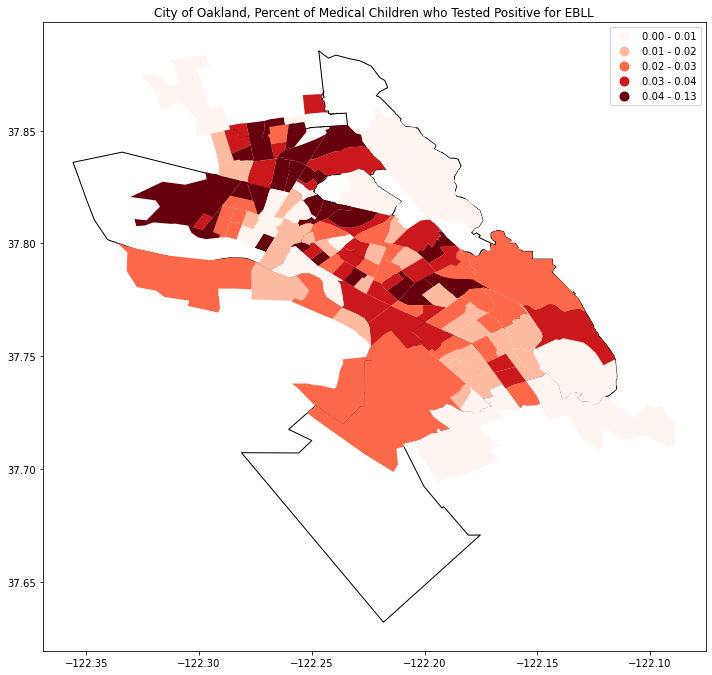

In [56]:
# Choropleth for 
fig, ax = plt.subplots(figsize = (10,10)) 

#add in the city of oakland boundaries
oakland_bounds.plot(color='white',
                edgecolor='slategrey',
                linewidth=.01,
                ax=ax)

#add the council districts as our background layer
oakland_cds.plot(color='white',
                edgecolor='black',
                linewidth=1,
                ax=ax)

o_gdf.plot(column='p_EBLL_of_Medical', 
         cmap='Reds',
         scheme='quantiles',
         legend=True,
#          legend_kwds={'label': "% Medical Children with Elevated Blood Lead Levels",
#                       'orientation': "horizontal"},
         ax=ax)

# Create titles
plt.tight_layout()
plt.title("City of Oakland, Percent of Medical Children who Tested Positive for EBLL")

# Save figure 
# plt.savefig("~/outdata/OaklandEBLL.png")

#plot hte figure
plt.show()

In [ ]:
#bring in the oakland city council districts
oaklandcds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland Council Districts.geojson')